Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [5]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_7605/2882021498.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = StandardScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Execution model
## Create model

In [10]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

Initialize model

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Construct Data Loader

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

    X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)
    model.eval()
    outputs = model(X_test_tensor)
    with torch.no_grad():
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float().cpu().numpy()
    
        # Calculate indicators
        acc = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
    
        print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)
    pbar.update(1)
    
pbar.reset()

  1%|          | 1/100 [00:11<18:55, 11.46s/it]

Epoch [1/100], Loss: 0.5801871593628078, Accuracy: 0.8689850278551532


  2%|▏         | 2/100 [00:22<18:26, 11.29s/it]

Epoch [2/100], Loss: 0.5365850359403136, Accuracy: 0.8717487813370474


  3%|▎         | 3/100 [00:33<18:13, 11.27s/it]

Epoch [3/100], Loss: 0.5256641213042218, Accuracy: 0.8713701253481894


  4%|▍         | 4/100 [00:45<18:04, 11.30s/it]

Epoch [4/100], Loss: 0.5324064232793763, Accuracy: 0.8684540389972145


  5%|▌         | 5/100 [00:57<18:19, 11.58s/it]

Epoch [5/100], Loss: 0.539833211919947, Accuracy: 0.873433147632312


  6%|▌         | 6/100 [01:08<17:51, 11.40s/it]

Epoch [6/100], Loss: 0.5448298765348313, Accuracy: 0.8697945682451254


  7%|▋         | 7/100 [01:19<17:29, 11.29s/it]

Epoch [7/100], Loss: 0.5478450931410053, Accuracy: 0.8672919568245125


  8%|▊         | 8/100 [01:30<17:21, 11.32s/it]

Epoch [8/100], Loss: 0.5451809479609823, Accuracy: 0.8688501044568245


  9%|▉         | 9/100 [01:42<17:12, 11.35s/it]

Epoch [9/100], Loss: 0.5420901293535141, Accuracy: 0.8698206824512534


 10%|█         | 10/100 [01:53<16:52, 11.25s/it]

Epoch [10/100], Loss: 0.5408468386130743, Accuracy: 0.870321204735376


 11%|█         | 11/100 [02:04<16:42, 11.26s/it]

Epoch [11/100], Loss: 0.540483039688054, Accuracy: 0.8707433844011142


 12%|█▏        | 12/100 [02:15<16:16, 11.09s/it]

Epoch [12/100], Loss: 0.540395448904428, Accuracy: 0.8707520891364903


 13%|█▎        | 13/100 [02:26<16:16, 11.23s/it]

Epoch [13/100], Loss: 0.5407869255550246, Accuracy: 0.8707172701949861


 14%|█▍        | 14/100 [02:37<16:01, 11.18s/it]

Epoch [14/100], Loss: 0.5416437471967309, Accuracy: 0.8629395891364903


 15%|█▌        | 15/100 [02:49<15:55, 11.24s/it]

Epoch [15/100], Loss: 0.5407430462266555, Accuracy: 0.8587395543175488


 16%|█▌        | 16/100 [03:00<15:43, 11.23s/it]

Epoch [16/100], Loss: 0.5350183590007639, Accuracy: 0.8606963505220011


 17%|█▋        | 17/100 [03:11<15:40, 11.33s/it]

Epoch [17/100], Loss: 0.5310886650299848, Accuracy: 0.8607845655841656


 18%|█▊        | 18/100 [03:23<15:25, 11.29s/it]

Epoch [18/100], Loss: 0.526245370892917, Accuracy: 0.8625673378513034


 19%|█▉        | 19/100 [03:34<15:05, 11.17s/it]

Epoch [19/100], Loss: 0.5233899121883455, Accuracy: 0.8637393632379917


 20%|██        | 20/100 [03:44<14:45, 11.07s/it]

Epoch [20/100], Loss: 0.5206884232018387, Accuracy: 0.8636660806893585


 21%|██        | 21/100 [03:55<14:26, 10.97s/it]

Epoch [21/100], Loss: 0.5155488849796538, Accuracy: 0.8631136838440111


 22%|██▏       | 22/100 [04:06<14:03, 10.82s/it]

Epoch [22/100], Loss: 0.5107708414625425, Accuracy: 0.8631441504178273


 23%|██▎       | 23/100 [04:16<13:44, 10.71s/it]

Epoch [23/100], Loss: 0.5054615693585461, Accuracy: 0.8645369080779944


 24%|██▍       | 24/100 [04:27<13:40, 10.79s/it]

Epoch [24/100], Loss: 0.4994131025702843, Accuracy: 0.8678272980501393


 25%|██▌       | 25/100 [04:38<13:33, 10.84s/it]

Epoch [25/100], Loss: 0.4936706872474087, Accuracy: 0.8688152855153203


 26%|██▌       | 26/100 [04:49<13:22, 10.84s/it]

Epoch [26/100], Loss: 0.4868812222350406, Accuracy: 0.8707999651810585


 27%|██▋       | 27/100 [05:00<13:18, 10.94s/it]

Epoch [27/100], Loss: 0.47873464808816857, Accuracy: 0.873446204735376


 28%|██▊       | 28/100 [05:11<13:02, 10.86s/it]

Epoch [28/100], Loss: 0.473571209704636, Accuracy: 0.8760097493036212


 29%|██▉       | 29/100 [05:21<12:49, 10.84s/it]

Epoch [29/100], Loss: 0.46131249784451517, Accuracy: 0.8851845403899722


 30%|███       | 30/100 [05:32<12:34, 10.78s/it]

Epoch [30/100], Loss: 0.4519176848442124, Accuracy: 0.8891277855153203


 31%|███       | 31/100 [05:43<12:26, 10.81s/it]

Epoch [31/100], Loss: 0.4278514444194632, Accuracy: 0.9028333913649025


 32%|███▏      | 32/100 [05:54<12:15, 10.82s/it]

Epoch [32/100], Loss: 0.412758207255837, Accuracy: 0.9084392409470752


 33%|███▎      | 33/100 [06:05<12:07, 10.85s/it]

Epoch [33/100], Loss: 0.3704993514821409, Accuracy: 0.9241208217270195


 34%|███▍      | 34/100 [06:16<12:00, 10.91s/it]

Epoch [34/100], Loss: 0.367061497373389, Accuracy: 0.9240816504178273


 35%|███▌      | 35/100 [06:27<11:48, 10.90s/it]

Epoch [35/100], Loss: 0.3212361428146873, Accuracy: 0.9368993732590529


 36%|███▌      | 36/100 [06:38<11:40, 10.94s/it]

Epoch [36/100], Loss: 0.31338589614997386, Accuracy: 0.937495647632312


 37%|███▋      | 37/100 [06:49<11:26, 10.90s/it]

Epoch [37/100], Loss: 0.29115784659419525, Accuracy: 0.9412952646239554


 38%|███▊      | 38/100 [06:59<11:15, 10.89s/it]

Epoch [38/100], Loss: 0.28227193417152685, Accuracy: 0.941804491643454


 39%|███▉      | 39/100 [07:10<10:58, 10.79s/it]

Epoch [39/100], Loss: 0.27121404638021085, Accuracy: 0.943184192200557


 40%|████      | 40/100 [07:21<10:53, 10.89s/it]

Epoch [40/100], Loss: 0.2793231289789305, Accuracy: 0.9417348537604456


 41%|████      | 41/100 [07:32<10:41, 10.88s/it]

Epoch [41/100], Loss: 0.2643958182732911, Accuracy: 0.94491643454039


 42%|████▏     | 42/100 [07:43<10:29, 10.86s/it]

Epoch [42/100], Loss: 0.2587311061213209, Accuracy: 0.947658426183844


 43%|████▎     | 43/100 [07:54<10:20, 10.89s/it]

Epoch [43/100], Loss: 0.2635259266998638, Accuracy: 0.9474233983286908


 44%|████▍     | 44/100 [08:04<10:07, 10.85s/it]

Epoch [44/100], Loss: 0.2609874258240575, Accuracy: 0.9488335654596101


 45%|████▌     | 45/100 [08:15<09:51, 10.76s/it]

Epoch [45/100], Loss: 0.2586748988353574, Accuracy: 0.9496256963788301


 46%|████▌     | 46/100 [08:26<09:39, 10.74s/it]

Epoch [46/100], Loss: 0.2580930243357152, Accuracy: 0.9499825905292479


 47%|████▋     | 47/100 [08:36<09:28, 10.72s/it]

Epoch [47/100], Loss: 0.2615378404154179, Accuracy: 0.9485854805013928


 48%|████▊     | 48/100 [08:47<09:21, 10.79s/it]

Epoch [48/100], Loss: 0.2555646736446596, Accuracy: 0.950182799442897


 49%|████▉     | 49/100 [08:59<09:20, 10.99s/it]

Epoch [49/100], Loss: 0.2535852873834443, Accuracy: 0.9514449860724234


 50%|█████     | 50/100 [09:10<09:14, 11.08s/it]

Epoch [50/100], Loss: 0.25488589202023304, Accuracy: 0.9503177228412256


 51%|█████     | 51/100 [09:21<09:03, 11.08s/it]

Epoch [51/100], Loss: 0.2528709348976131, Accuracy: 0.9505658077994429


 52%|█████▏    | 52/100 [09:32<08:51, 11.08s/it]

Epoch [52/100], Loss: 0.24395477349077796, Accuracy: 0.9517365947075209


 53%|█████▎    | 53/100 [09:43<08:38, 11.03s/it]

Epoch [53/100], Loss: 0.2630346171223288, Accuracy: 0.9481415389972145


 54%|█████▍    | 54/100 [09:54<08:29, 11.08s/it]

Epoch [54/100], Loss: 0.24727602679803215, Accuracy: 0.9520673746518106


 55%|█████▌    | 55/100 [10:06<08:22, 11.18s/it]

Epoch [55/100], Loss: 0.2479212143977698, Accuracy: 0.9512447771587744


 56%|█████▌    | 56/100 [10:17<08:08, 11.10s/it]

Epoch [56/100], Loss: 0.2586277982149744, Accuracy: 0.9490468314763231


 57%|█████▋    | 57/100 [10:28<07:56, 11.08s/it]

Epoch [57/100], Loss: 0.24874939674227217, Accuracy: 0.9510576253481894


 58%|█████▊    | 58/100 [10:39<07:47, 11.12s/it]

Epoch [58/100], Loss: 0.2389364067208706, Accuracy: 0.9531946378830084


 59%|█████▉    | 59/100 [10:49<07:28, 10.95s/it]

Epoch [59/100], Loss: 0.24340671656215587, Accuracy: 0.9512839484679666


 60%|██████    | 60/100 [11:00<07:17, 10.93s/it]

Epoch [60/100], Loss: 0.2311625968772328, Accuracy: 0.9544350626740947


 61%|██████    | 61/100 [11:11<06:59, 10.76s/it]

Epoch [61/100], Loss: 0.23643367664980178, Accuracy: 0.9520717270194986


 62%|██████▏   | 62/100 [11:21<06:48, 10.76s/it]

Epoch [62/100], Loss: 0.2246699011786669, Accuracy: 0.9549312325905293


 63%|██████▎   | 63/100 [11:32<06:36, 10.72s/it]

Epoch [63/100], Loss: 0.22755484068385143, Accuracy: 0.9539345403899722


 64%|██████▍   | 64/100 [11:43<06:24, 10.67s/it]

Epoch [64/100], Loss: 0.21542909980794564, Accuracy: 0.9570029596100279


 65%|██████▌   | 65/100 [11:53<06:14, 10.69s/it]

Epoch [65/100], Loss: 0.21388488292357785, Accuracy: 0.9569550835654597


 66%|██████▌   | 66/100 [12:04<06:05, 10.74s/it]

Epoch [66/100], Loss: 0.19983544154457095, Accuracy: 0.9615555362116992


 67%|██████▋   | 67/100 [12:15<05:56, 10.79s/it]

Epoch [67/100], Loss: 0.19379425037640188, Accuracy: 0.9629134749303622


 68%|██████▊   | 68/100 [12:27<05:51, 10.99s/it]

Epoch [68/100], Loss: 0.18929103358556687, Accuracy: 0.9648067548746518


 69%|██████▉   | 69/100 [12:38<05:40, 10.99s/it]

Epoch [69/100], Loss: 0.17472816232935814, Accuracy: 0.9674486420612813


 70%|███████   | 70/100 [12:49<05:31, 11.06s/it]

Epoch [70/100], Loss: 0.16416223295020302, Accuracy: 0.9716312674094707


 71%|███████   | 71/100 [13:00<05:21, 11.09s/it]

Epoch [71/100], Loss: 0.15388752054984284, Accuracy: 0.9727237116991644


 72%|███████▏  | 72/100 [13:11<05:09, 11.04s/it]

Epoch [72/100], Loss: 0.15480111386199896, Accuracy: 0.9737160515320334


 73%|███████▎  | 73/100 [13:22<04:56, 10.99s/it]

Epoch [73/100], Loss: 0.14510183511901237, Accuracy: 0.9745908774373259


 74%|███████▍  | 74/100 [13:33<04:44, 10.95s/it]

Epoch [74/100], Loss: 0.14012980129488298, Accuracy: 0.9764101671309192


 75%|███████▌  | 75/100 [13:43<04:31, 10.88s/it]

Epoch [75/100], Loss: 0.134614174545054, Accuracy: 0.9780466573816156


 76%|███████▌  | 76/100 [13:54<04:20, 10.86s/it]

Epoch [76/100], Loss: 0.1294899933591678, Accuracy: 0.979500348189415


 77%|███████▋  | 77/100 [14:05<04:11, 10.93s/it]

Epoch [77/100], Loss: 0.1283871676955464, Accuracy: 0.9793175487465181


 78%|███████▊  | 78/100 [14:16<04:00, 10.93s/it]

Epoch [78/100], Loss: 0.12697258537613829, Accuracy: 0.9795786908077995


 79%|███████▉  | 79/100 [14:27<03:51, 11.02s/it]

Epoch [79/100], Loss: 0.12402365124222857, Accuracy: 0.9804839832869081


 80%|████████  | 80/100 [14:39<03:45, 11.30s/it]

Epoch [80/100], Loss: 0.12520202849025497, Accuracy: 0.9786777506963789


 81%|████████  | 81/100 [14:51<03:38, 11.48s/it]

Epoch [81/100], Loss: 0.12747175991377982, Accuracy: 0.9791260445682451


 82%|████████▏ | 82/100 [15:03<03:25, 11.43s/it]

Epoch [82/100], Loss: 0.12400320503091021, Accuracy: 0.977942200557103


 83%|████████▎ | 83/100 [15:15<03:16, 11.57s/it]

Epoch [83/100], Loss: 0.11955639937467186, Accuracy: 0.9791391016713092


 84%|████████▍ | 84/100 [15:26<03:04, 11.55s/it]

Epoch [84/100], Loss: 0.12235288013666153, Accuracy: 0.9780771239554318


 85%|████████▌ | 85/100 [15:38<02:53, 11.57s/it]

Epoch [85/100], Loss: 0.11401401336544578, Accuracy: 0.9801053272980501


 86%|████████▌ | 86/100 [15:49<02:40, 11.46s/it]

Epoch [86/100], Loss: 0.11973454814143622, Accuracy: 0.9780945334261838


 87%|████████▋ | 87/100 [15:59<02:24, 11.10s/it]

Epoch [87/100], Loss: 0.11285213499770406, Accuracy: 0.9798354805013928


 88%|████████▊ | 88/100 [16:10<02:12, 11.01s/it]

Epoch [88/100], Loss: 0.11607084911041668, Accuracy: 0.9787822075208914


 89%|████████▉ | 89/100 [16:21<02:00, 10.99s/it]

Epoch [89/100], Loss: 0.11171383103162956, Accuracy: 0.9799573467966574


 90%|█████████ | 90/100 [16:32<01:49, 10.95s/it]

Epoch [90/100], Loss: 0.11568970676111455, Accuracy: 0.978886664345404


 91%|█████████ | 91/100 [16:43<01:38, 10.97s/it]

Epoch [91/100], Loss: 0.1096641353337064, Accuracy: 0.9807059540389972


 92%|█████████▏| 92/100 [16:54<01:27, 10.94s/it]

Epoch [92/100], Loss: 0.11577348765208495, Accuracy: 0.9795917479108636


 93%|█████████▎| 93/100 [17:04<01:16, 10.90s/it]

Epoch [93/100], Loss: 0.11366767121961462, Accuracy: 0.9787604456824512


 94%|█████████▍| 94/100 [17:15<01:05, 10.92s/it]

Epoch [94/100], Loss: 0.10790928888382065, Accuracy: 0.9809192200557103


 95%|█████████▌| 95/100 [17:26<00:54, 10.89s/it]

Epoch [95/100], Loss: 0.11264526004189644, Accuracy: 0.9787256267409471


 96%|█████████▌| 96/100 [17:37<00:43, 10.86s/it]

Epoch [96/100], Loss: 0.10987918001384195, Accuracy: 0.9797876044568246


 97%|█████████▋| 97/100 [17:47<00:32, 10.76s/it]

Epoch [97/100], Loss: 0.10620300054341474, Accuracy: 0.980658077994429


 98%|█████████▊| 98/100 [17:58<00:21, 10.67s/it]

Epoch [98/100], Loss: 0.10936488255788934, Accuracy: 0.9792696727019499


 99%|█████████▉| 99/100 [18:08<00:10, 10.60s/it]

Epoch [99/100], Loss: 0.11238121714838151, Accuracy: 0.9789519498607242


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.10420266107797725, Accuracy: 0.9805666782729805


Visualizing the training process

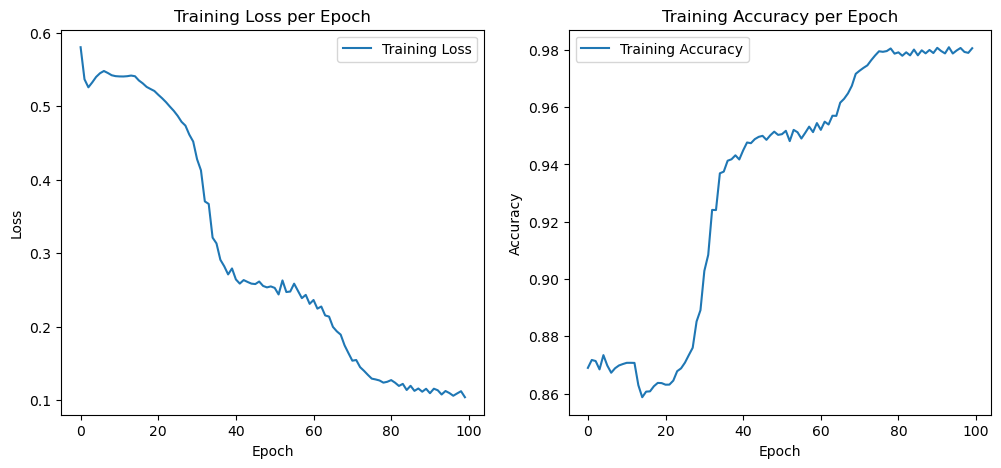

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.7225578439736068 , Precision:  0.32616984402079724 , Recall:  0.9514661274014156 , F1:  0.4858027878162106


Save model

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_rnn_{current_time}.pt"
full_path = os.path.join(save_folder, model_filename)
torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: model_2023-11-22_05-48-02.pt
